In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut, GeocoderServiceError
import json
from random import randint
from shapely.geometry import Point, Polygon
from time import sleep
import os

In [2]:
def compute_based_town_boundaries(data_file, tolerance=0.01):
    with open(data_file, 'r') as fichier_json :
        data = json.load(fichier_json)
        lyon_shape = Polygon(data)
        del data
        print("Complexité originale de la frontière : " ,len(lyon_shape.exterior.coords))
        x, y = lyon_shape.exterior.xy
        plt.plot(x, y, label='Polygone Non Simplifié', color='red')
        
        # Simplifier le polygone
        lyon_shape = lyon_shape.simplify(tolerance)
        print("Complexité simplifiée de la frontière : ", len(lyon_shape.exterior.coords))
        
        x, y = lyon_shape.exterior.xy
        plt.plot(x, y, label='Polygone Non Simplifié', color='blue')
        return lyon_shape

In [3]:
def find_dest_towns(based_town_shape, file_name, tmp_file_name, precision=2, duration_threeshold=60):
    
    def check_time_spent(group, reduced_data):
        group = group.sort_values(by="date")
        time_spent = (group['date'].iloc[group.shape[0]-1] - group['date'].iloc[0]).seconds
        if time_spent >= duration_threeshold:
            # C'est un endroit où l'individu a passé au moins duration_threeshold secondes
            # donc potentiellement une destination
            # on check si c'est différent de Lyon
            gps = (group['long'].iloc[0], group['lat'].iloc[0])
            if not based_town_shape.contains(Point(gps)):
                reduced_data['id'].append(group['id'].iloc[0])
                reduced_data['date'].append(group['date'].iloc[0].strftime("%Y-%m-%d %H:%M:%S"))
                reduced_data['long'].append(gps[0])
                reduced_data['lat'].append(gps[1])

        return reduced_data
    
    df = pd.read_csv(file_name, delimiter= '\t', header=None)
    df.columns = ["id","date", "long", "lat"]
    df = df[df['id'] != "DEL"]

    columns_types = {'id' : str, 'date': str, 'long': np.float32, 'lat': np.float32}
    df = df.astype(columns_types)
    df['date'] = pd.to_datetime(df['date'], format="%Y-%m-%d %H:%M:%S")
    df['long'] = df['long'].apply(lambda x : round(x, precision))
    df['lat'] = df['lat'].apply(lambda x : round(x, precision))
    df = df.sort_values(by="id")
    
    reduced_data = {'id': [], 'date': [], 'long': [], 'lat': []}
    # Grouper par coordonnée et id et vérifier le temps passé à la coordonnée
    df.groupby(by=["id", "long", "lat"], group_keys=True, sort=False).apply(check_time_spent, reduced_data)
    
    try:
        os.remove(tmp_file_name)
    except OSError as e:
        None
    pd.DataFrame(reduced_data).to_csv(tmp_file_name, sep="\t", index=False, header=False)
    return

In [4]:
#=======================================================================
# Première métrique : Calculer la proportion de Lyonnais qui s’est 
# déplacée dans une autre ville française
#=======================================================================

def reverse_geocode(geolocator, gps, sleep_sec):
    try:
        return geolocator.reverse(gps)
    except GeocoderTimedOut:
        print("Sleeping")
        sleep(randint(1*100,sleep_sec*100)/100)
        return reverse_geocode(geolocator, gps, sleep_sec)
    except GeocoderServiceError as e:
        return None
    except Exception as e:
        return None
    
def compute_metrique1(file_name, precision=2):
    BASED_COUNTRY = "France".lower()
    # Pré-requis : file_name est le chemin du fichier généré par la fonction find_dest_towns() précédente
    # Il contient uniquement les enregistrements où la ville est différente de Lyon et l'individu a passé 
    # un certain temps
    towns_visited = dict()
    travellers_counter = 0
    fd_original = open(file_name, newline='')
    original_reader = csv.reader(fd_original, delimiter="\t")
    user_agent = 'user_me_{}'.format(randint(10000,99999))
    geolocator = Nominatim(user_agent=user_agent)
    banned_gps = set()
    
    for row in original_reader:        
        key = row[0]
        if "DEL" != key[0 :3].upper():
            gps = (round(float(row[2]), precision), round(float(row[3]), precision))
            town_gps = (round(gps[0], precision-1), round(gps[1], precision-1))
            #town_gps = gps
            if town_gps in towns_visited :
                towns_visited[town_gps]['keys'].add(key)
                continue
            if town_gps in banned_gps:
                continue
                                  
            print("Requete" , travellers_counter+1, " id :", key, " gps : ", town_gps)
            location = reverse_geocode(geolocator, reversed(gps), 5)
            if location:
                str_location = f"{location}".split(', ')
                if len(str_location) >= 2 :
                    current_country, current_town = (str_location[-1].lower(), str_location[-2])
                    if current_country == BASED_COUNTRY:
                        #print("Nouvelle ville ", current_town, "\n")
                        travellers_counter += 1
                        if town_gps not in towns_visited:
                            towns_visited[town_gps] = {'zip_code': current_town, 'keys': set()}
                            towns_visited[town_gps]['keys'].add(key)
                    else:
                        print("Autre pays : ", current_country)
                        banned_gps.add(town_gps)
            else :
                print("Error during retrieving localisations data")
                banned_gps.add(town_gps)
                
    towns_counter = {}
    for town in towns_visited:
        if not towns_visited[town]['zip_code'] in towns_counter:
            towns_counter[towns_visited[town]['zip_code']] = set(towns_visited[town]['keys'])
            
        else:
            towns_counter[towns_visited[town]['zip_code']] |= set(towns_visited[town]['keys'])

    print(towns_counter)
    towns_counter = {key: val for key, val in sorted({k: len(v) for k, v in towns_counter.items()}.items(), key = lambda ele: ele[1], reverse=True)} 
    print(towns_counter, "\n", travellers_counter)
    return towns_counter

In [5]:
def compute_score(utility_noanon, utility_anon):
    score = 0
    for postal_code in utility_noanon :
        if postal_code in utility_anon :
            count_noanon = utility_noanon[postal_code]
            count_anon = utility_anon[postal_code]
            score += (count_anon / count_noanon) if count_anon < count_noanon else (count_noanon / count_anon)
    score /= len(utility_noanon)
    assert 0 <= score <= 1
    return score

Complexité originale de la frontière :  9924
Complexité simplifiée de la frontière :  73


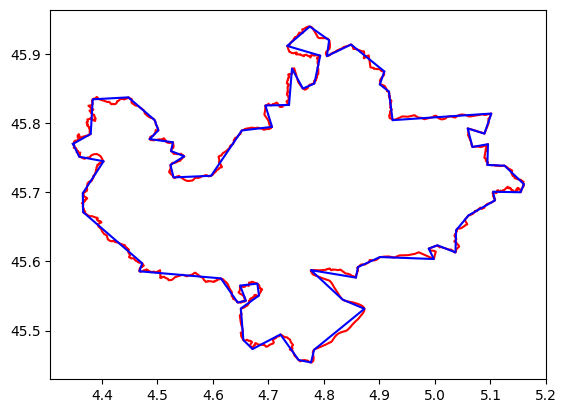

In [6]:
LYON_SHAPE = compute_based_town_boundaries(data_file='limitesMetropole.json', tolerance=0.01)
def measure(file_noanon, file_anon, tmp_file, gps_precision=2):
    find_dest_towns(LYON_SHAPE, file_noanon, tmp_file, gps_precision, duration_threeshold=60)
    result_noanon = compute_metrique1(tmp_file, gps_precision)
    
    find_dest_towns(LYON_SHAPE, file_anon, tmp_file, gps_precision, duration_threeshold=60)
    result_anon = compute_metrique1(tmp_file, gps_precision)
    return result_noanon, result_anon, compute_score(result_noanon, result_anon)

In [ ]:
a, b, c = measure("../truth_ground.csv", "../partieAttaque/Vinanonyme/submit701.csv", 'tmp/filtered_data.csv')

In [ ]:
print(len(a), len(b), c)

In [ ]:
#LYON_SHAPE = compute_based_town_boundaries(data_file='limitesMetropole.json', tolerance=0.01)
find_dest_towns(LYON_SHAPE, "../partieAttaque/Frangipane/submit659.csv", 'tmp/filtered_data.csv', 2, duration_threeshold=60)
result_anon = compute_metrique1('tmp/filtered_data.csv', 2)
print(compute_score(a, result_anon))